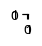

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# init

In [2]:
import csv
def get_metadata(filename):
    # Initialize a dictionary to hold the header information
    metadatares = {'filename':os.path.basename(filename)}
    metadatares['relpath']=filename
    # Read the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Read the first line which contains the metadata
        metadata_line = next(reader)[0]
        # Convert the metadata line to a dictionary
        metadata = eval(metadata_line)
    metadatares.update(metadata)
    return metadatares
    
def read_ots_data(filename):
    metadata = get_metadata(filename)
    df = pd.read_csv(filename, skiprows=1)
    df = df[[c for c in df.columns if ('aa' in c.lower() and 'cdr' in c.lower()) or 'call' in c.lower()]]
    df.columns = [x.replace('cdr','').replace('_aa_','').replace('beta','B').replace('alpha','A')[::-1] if 'cdr' in x else x for x in df.columns]
    df.columns = df.columns.str.replace('_call','')
    df['Link']=metadata['Link']
    df['Disease']=metadata['Disease']
    df['CancerType']=metadata['CancerType']
    df['Source']=metadata['TSource']
    df['Subject']=metadata['Subject']
    return df, metadata


def plot_prune_heatmap(values, threshold, title, 
                       filename=None, outdir='../output/240618_NestedKCV_CNNVAE/notebook_figs/',
                       sorted_dm=None,
                       cmap='vlag', color='g', addline=True):
    # prune and plot the heatmap
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=values.max(), cbar_ax=cbar_ax, cmap=cmap)
    # Set up custom tickmarks if available
    if sorted_dm is not None:
        pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
        pepmap['idx']=pepmap['count'].cumsum()
        pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
        tickmarks = pepmap['tick'].to_dict() 
        idxs = pepmap['idx'].to_dict()
        ax.set_xticks(list(tickmarks.values()))
        ax.set_yticks(list(tickmarks.values()))
        ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
        ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline and sorted_dm is not None:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    if filename is not None:
        f.savefig(f'{outdir}{filename}.png', dpi=150, bbox_inches='tight')
    plt.close()
    del f, ax

def do_all(filename, model, noplot=False, unique=False, outdir='../output/240820_HumanRepertoires/'):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    if unique:
        df.drop_duplicates(subset=['tcr'], inplace=True)
    metadata['n_seq'] = len(df)
    metadata['n_unique'] = len(df['tcr'].unique())
    pd.DataFrame(metadata, index=[0]).to_csv(f"{outdir}metadata/{metadata['Run']}_metadata.txt", index=False)
    if noplot:
        return 0
    else:
            
        if len(glob.glob(f'{outdir}heatmaps/*{metadata["Run"]}*'))>0:
            return 0
    
        latent_df = get_latent_df(model, df)
        latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
        _, values_array, _, _, _, _ = get_distances_labels_from_latent(latent_df, 
                                                                       label_col='Disease', 
                                                                       index_col='index_col',
                                                                       rest_cols=['Disease','CancerType','Source'],
                                                                       low_memory=True)
        
        latent_df['tcr'] = latent_df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
        n_seq=len(latent_df)
        n_unique=len(latent_df['tcr'].unique())
        plot_prune_heatmap(values_array, threshold=10, title=f"{metadata['Run']}, n_seq={n_seq}, n_unique={n_unique}", 
                           filename=f'{metadata["Run"]}_n-{n_seq}_unique-{n_unique}',
                           outdir=f'{outdir}heatmaps/', addline=False, sorted_dm=None)
        print(metadata['Run'], '\t', n_seq, '\t', n_unique)
        del latent_df
    # latent_df.groupby(['tcr']).agg(count=('B1','count')).sort_values('count',ascending=False)

In [7]:
def read_ots_unique(filename):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    metadata['n_seq'] = len(df)
    metadata['unique'] = len(df.tcr.unique())
    counts = df.groupby('tcr').agg(count=('B3','count'))
    df = df.drop_duplicates(subset=['tcr'])
    df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
    df['Run']=metadata['Run']
    return df, metadata

In [3]:
meta_df = pd.read_csv('../data/OTS/human/METADATA.txt')
meta_df.groupby(['Link','Author']).agg(disease=('Disease','unique'),
                                      n_repertoires=('Disease','count'),
                                      mean_size=('Sequences', 'mean'),
                                      mean_unique=('n_unique','mean'))

,,disease,n_repertoires,mean_size,mean_unique
Link,Author,,,,
https://pubmed.ncbi.nlm.nih.gov/33478949/,Kusnadi et al. 2021,[covid],15,4657.133333,734.266667
https://pubmed.ncbi.nlm.nih.gov/34156975/,"Peng et al., 2021",[herpes_simplex_virus_type_2],4,1324.250000,681.250000
https://pubmed.ncbi.nlm.nih.gov/34793243/,Francis et al. 2021,[covid],95,1655.589474,821.357895
https://pubmed.ncbi.nlm.nih.gov/36516854/,Yu et al. 2022,[cmv],6,2545.833333,733.500000
https://pubmed.ncbi.nlm.nih.gov/37580605/,Garner et al.,[healthy],96,5587.364583,1663.104167
https://www.nature.com/articles/s41590-022-01367-z,Xu et al. 2023,[covid],8,4370.750000,3346.875000
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10201342/,Eberhardt et al. 2021,[cancer],51,1234.333333,191.705882


# re-make francis healthy data with low healthy counts

# Do run merging Covid (Francis) and Healthy (Garner) studies

## save with low counts

<Axes: title={'center': 'Garner Healthy'}, ylabel='Frequency'>

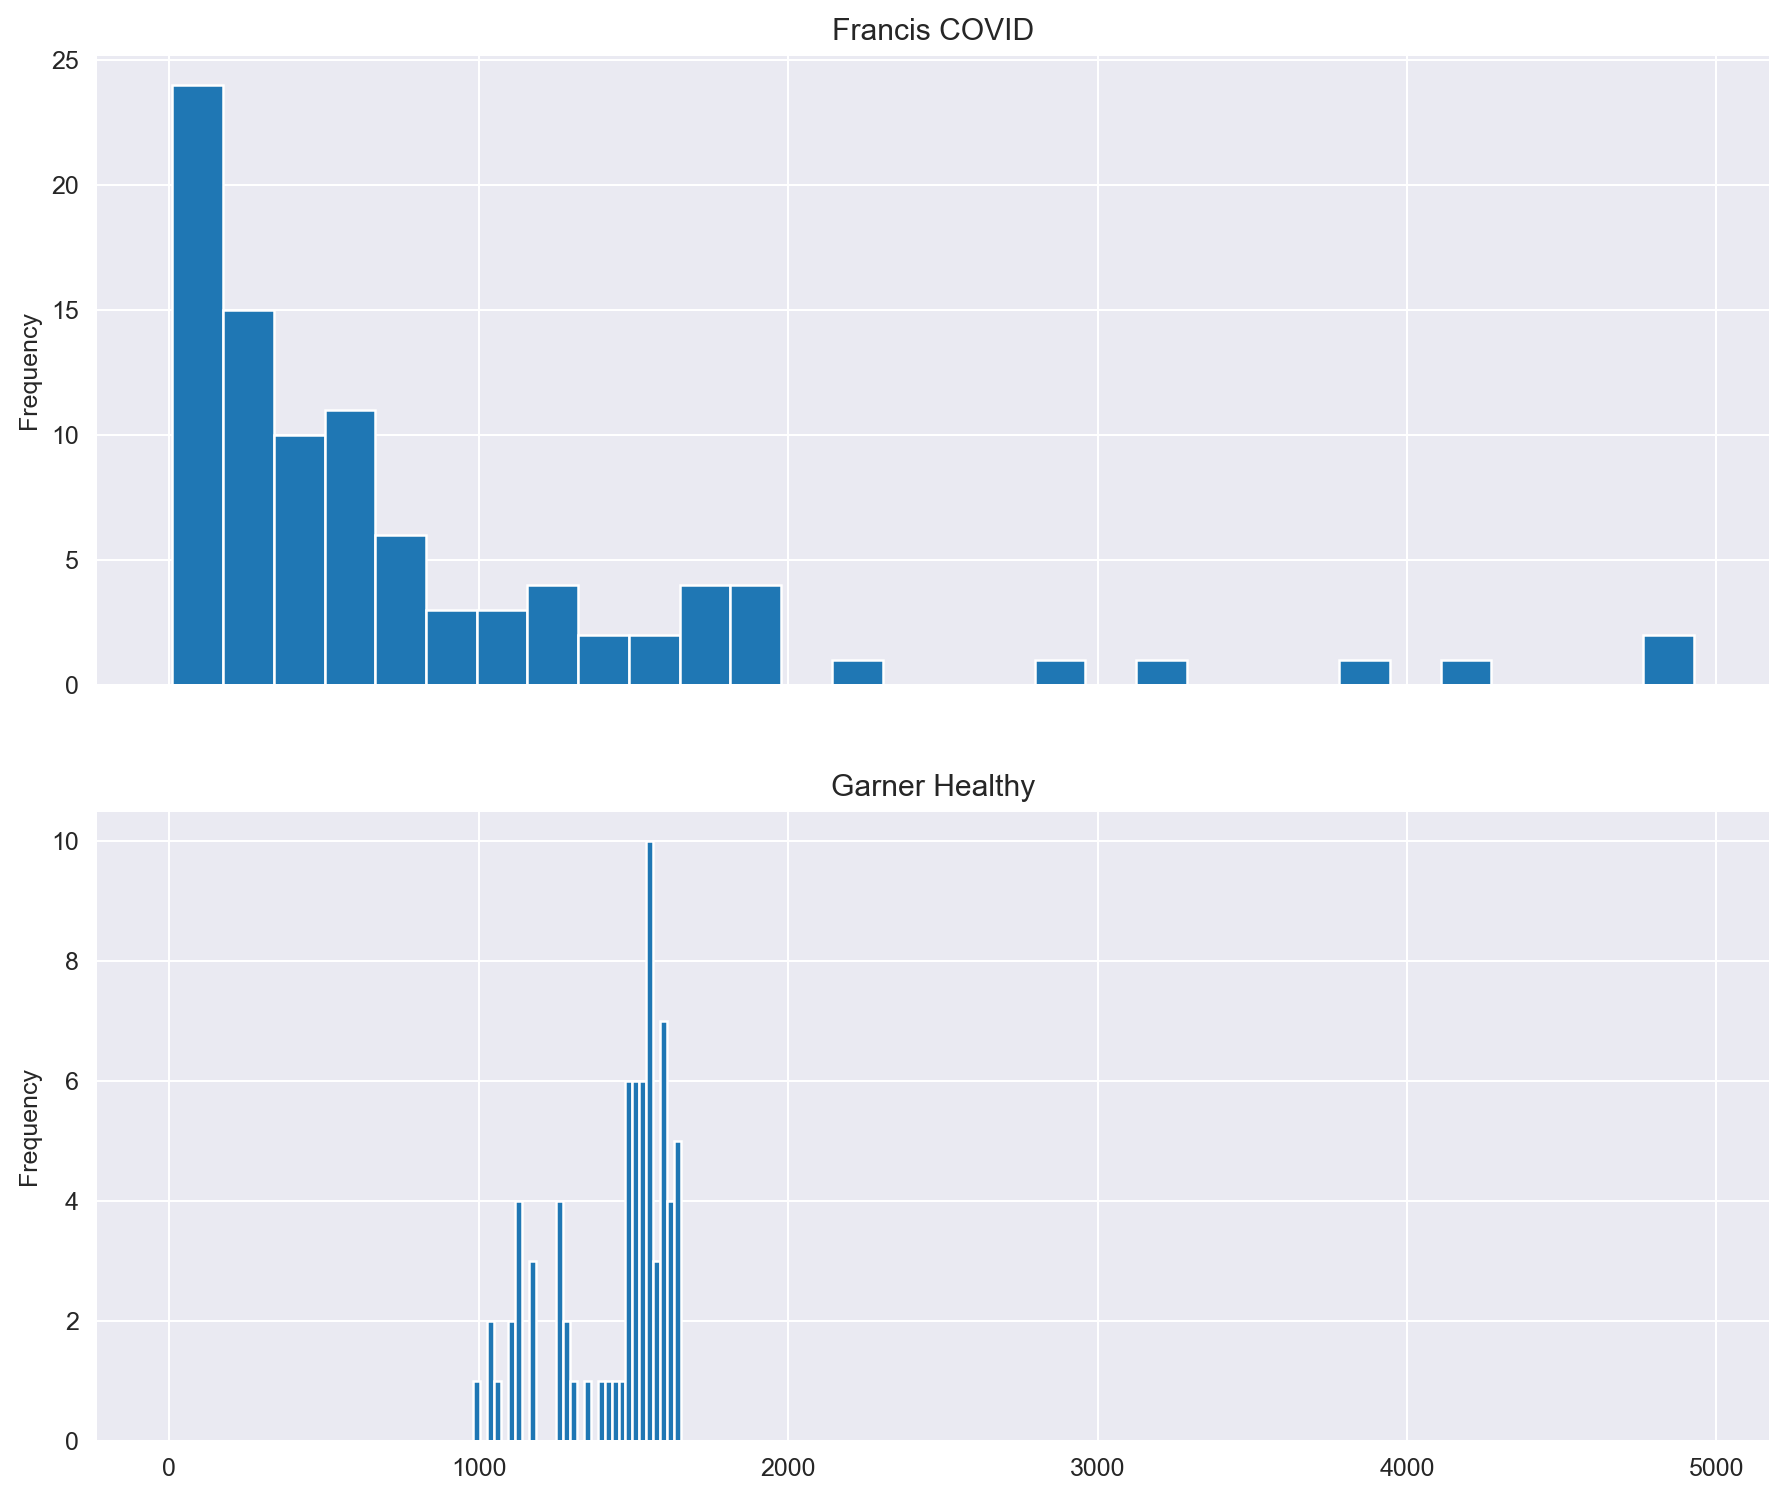

In [9]:
garner_pbmc = meta_df.query('Author.str.contains("Garner")').query('TSource=="pbmc"')
francis_pbmc = meta_df.query('Author.str.contains("Franc")')
f,a = plt.subplots(2,1, figsize=(12,10), sharex=True)
ax = a.ravel()
francis_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[0], title='Francis COVID')
garner_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[1], title='Garner Healthy')

In [16]:
%mkdir ../data/OTS/subsampled_covid_healthy_lowcount/
garner_3 = pd.read_csv('../data/OTS/garner_merged/garner_merged_41_42_43.csv').query('mean_count<2')
garner_3.query('mean_count==1')

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,CancerType,Source,Subject,count,Run,duplicated,n_dupes,mean_count,max_count,index_col
0,ATGYPSATKADDKAFMDTGRRALTSGHTAFQGTGAASSQVGGGTDTQY,TRBV7-3*01,TRBD2*01,TRBJ2-3*01,SGHTA,FQGTGA,ASSQVGGGTDTQY,TRAV9-2*01,NaN,TRAJ5*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409126,True,6.0,1.0,1.0,garner_00000
2,ATGYPSATKADDKALCLYGGATNKLIMNHNYSVGAGIASSPTELPS...,TRBV6-6*01,TRBD2*02,TRBJ2-7*01,MNHNY,SVGAGI,ASSPTELPSYEQY,TRAV9-2*02,NaN,TRAJ32*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409221,True,3.0,1.0,1.0,garner_00002
3,ATGYPSATKADDKALESSGGSYIPTDFQATTSNEGSKASAIHLERA...,TRBV20-1*01,TRBD2*01,TRBJ2-7*01,DFQATT,SNEGSKA,SAIHLERAGEQY,TRAV9-2*01,NaN,TRAJ6*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409234,True,7.0,1.0,1.0,garner_00003
5,ATGYPSATKADDKALFQAGTALIDFQATTSNEGSKASASSGSSYNEQF,TRBV20-1*01,TRBD2*02,TRBJ2-1*01,DFQATT,SNEGSKA,SASSGSSYNEQF,TRAV9-2*02,NaN,TRAJ15*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409167,True,4.0,1.0,1.0,garner_00005
6,ATGYPSATKADDKALGSKTSYDKVISGHNTYENEEAASSLDFTGAR...,TRBV11-3*01,TRBD1*01,TRBJ2-2*01,SGHNT,YENEEA,ASSLDFTGARTGELF,TRAV9-2*02,NaN,TRAJ50*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409111,True,5.0,1.0,1.0,garner_00006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,YSGSPEHISRAPFSGGYNKLILNHDASQIVNDASSIDPGSGADTQY,TRBV19*01,TRBD1*01,TRBJ2-3*01,LNHDA,SQIVND,ASSIDPGSGADTQY,TRAV16*01,NaN,TRAJ4*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409234,True,21.0,1.0,1.0,garner_09999
10000,YSGSPEHISRAPGGYQKVTMNHNSSASEGTASSEAPELGEQY,TRBV6-1*01,NaN,TRBJ2-7*01,MNHNS,SASEGT,ASSEAPELGEQY,TRAV16*01,NaN,TRAJ13*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409180,True,4.0,1.0,1.0,garner_10000
10001,YSGSPEHISRAPHTGGFKTIMDHENSYDVKMASSPGQRDTGELF,TRBV28*01,TRBD1*01,TRBJ2-2*01,MDHEN,SYDVKM,ASSPGQRDTGELF,TRAV16*01,NaN,TRAJ9*01,...,none,pbmc,4.1_4.2_4.3,1,SRR25409121,True,3.0,1.0,1.0,garner_10001
10004,YSGSPEHISRASSDGQKLLMNHNSSASEGTASTSLGGSVGELF,TRBV6-1*01,TRBD1*01,TRBJ2-2*01,MNHNS,SASEGT,ASTSLGGSVGELF,TRAV16*01,NaN,TRAJ16*02,...,none,pbmc,4.1_4.2_4.3,1,SRR25409232,True,12.0,1.0,1.0,garner_10004


In [18]:
garner_3 = garner_3.query('mean_count==1')

In [26]:
def save_sub(fr, garner_3, seed):
    fn=f'../data/OTS/subsampled_covid_healthy_lowcount/subsampled_francis_{i:03}_seed_{seed:03}.txt'
    if os.path.exists(fn):
        df = pd.read_csv(fn)
        return (fn, df.duplicated(['tcr']).any())
    sub = garner_3.sample(n=len(fr), random_state=seed)
    cat = pd.concat([fr, sub]).reset_index(drop=True)
    cat['norm_count'] = cat.apply(lambda x: x['count'] / cat.groupby(['Disease'])['count'].sum()[x['Disease']], axis=1)

    cat.to_csv(f'../data/OTS/subsampled_covid_healthy_lowcount/subsampled_francis_{i:03}_seed_{seed:03}.txt', index=False)
    return (fn, cat.duplicated(['tcr']).any())


In [34]:
%ls ../data/OTS/subsampled_covid_healthy_lowcount

subsampled_francis_000_seed_000.txt  subsampled_francis_021_seed_050.txt
subsampled_francis_000_seed_001.txt  subsampled_francis_021_seed_051.txt
subsampled_francis_000_seed_002.txt  subsampled_francis_021_seed_052.txt
subsampled_francis_000_seed_003.txt  subsampled_francis_021_seed_053.txt
subsampled_francis_000_seed_004.txt  subsampled_francis_021_seed_054.txt
subsampled_francis_000_seed_005.txt  subsampled_francis_021_seed_055.txt
subsampled_francis_000_seed_006.txt  subsampled_francis_021_seed_056.txt
subsampled_francis_000_seed_007.txt  subsampled_francis_021_seed_057.txt
subsampled_francis_000_seed_008.txt  subsampled_francis_021_seed_058.txt
subsampled_francis_000_seed_009.txt  subsampled_francis_021_seed_059.txt
subsampled_francis_000_seed_010.txt  subsampled_francis_021_seed_060.txt
subsampled_francis_000_seed_011.txt  subsampled_francis_021_seed_061.txt
subsampled_francis_000_seed_012.txt  subsampled_francis_021_seed_062.txt
subsampled_francis_000_seed_013.txt  subsampled_fra

In [27]:
from joblib import Parallel, delayed
# Stop at 43 because that gives us a dataframe with 1521 seq and that's largest we could run without taking 16 hours
for i in tqdm(range(44), desc='i'):
    fr = pd.read_csv(f'../data/OTS/francis_covid/francis_{i:04}.txt', index_col=0)
    out=Parallel(n_jobs=10)(delayed(save_sub)(fr, garner_3.query('tcr not in @fr.tcr.unique()'), 
                                              seed) for seed in tqdm(range(100),leave=False,position=0))

mkdir: ../data/OTS/subsampled_francis_garner/: File exists


i:   0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## Results

# QVD/KSA/exp_df similarities?

In [48]:
exp_df = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv')
train_df = exp_df.query('partition!=0 and partition!=1')
cancer = pd.concat([pd.read_csv(x) for x in glob.glob('../data/OTS/eberhardt_cancer/*.txt')])
cancer['peptide'] = cancer['TSubtype'].apply(lambda x: 'QVD' if 'qvd' in x.lower() else 'KSA')
cancer.head()

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,...,Link,Disease,CancerType,Source,Subject,count,Run,TSubtype,index_col,peptide
0,YGATPYYFSGDTLVAVGATLTGNQFYSEHNRFQNEAQASSPGGETG...,TRBV7-9*03,TRBD1*01,TRBJ2-3*01,SEHNR,FQNEAQ,ASSPGGETGGIEDTQY,TRAV8-3*01,NaN,TRAJ49*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,4,SRR15178231,tetramer_ksa,hpv51_ksa_000,KSA
1,TSESDYYQEAYKQQNAYRSAGAQKLVMGHRAYSYEKLASSLEGRDL...,TRBV4-1*01,TRBD1*01,TRBJ2-1*01,MGHRA,YSYEKL,ASSLEGRDLIFEQF,TRAV38-2/DV8*01,NaN,TRAJ54*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,5,SRR15178231,tetramer_ksa,hpv51_ksa_001,KSA
2,SSYSPSYTSAATLVVVSDRNSAGNKLTSEHNRFQNEAQASSSQTSG...,TRBV7-9*03,TRBD2*01,TRBJ2-5*01,SEHNR,FQNEAQ,ASSSQTSGGGETQY,TRAV8-2*01,NaN,TRAJ17*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178231,tetramer_ksa,hpv51_ksa_002,KSA
3,SIFNTLYKAGELAGQLRGSGNTPLVSGHTAFQGTGAASSLGTSMDTQY,TRBV7-3*01,TRBD2*01,TRBJ2-3*01,SGHTA,FQGTGA,ASSLGTSMDTQY,TRAV35*01,NaN,TRAJ29*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178233,tetramer_ksa,hpv51_ksa_003,KSA
4,YGATPYYFSGDTLVAVGVTLTGNQFYSEHNRFQNEAQASSPGGETG...,TRBV7-9*03,TRBD1*01,TRBJ2-3*01,SEHNR,FQNEAQ,ASSPGGETGGIEDTQY,TRAV8-3*01,NaN,TRAJ49*01,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,tumor,hpv51,1,SRR15178233,tetramer_ksa,hpv51_ksa_004,KSA


In [51]:
pd.concat([cancer.assign(dataset='cancer_mixed', partition=-1), 
           train_df.assign(dataset='exp_train', TSubtype='train',
                           Run='nettcr_exp').rename(columns={'raw_index':'index_col'})]).to_csv('../data/OTS/cancer_train_mixed.csv')


In [54]:
dm = pd.read_csv('../data/OTS/cancer_train_mixed_TBCR_distmatrix.csv', index_col=0)
dm

,0,1,2,3,4,5,6,7,8,9,...,6017,6018,6019,6020,6021,peptide,Run,index_col,TSubtype,dataset
q_index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.207734,0.147773,0.189828,0.009479,0.203837,0.184994,0.176461,0.200627,0.187541,...,0.216445,0.203983,0.173823,0.222485,0.178605,KSA,SRR15178231,hpv51_ksa_000,tetramer_ksa,cancer_mixed
1,0.207734,0.000000,0.196881,0.180998,0.214543,0.193051,0.189451,0.192982,0.189236,0.181932,...,0.170789,0.192680,0.197005,0.219683,0.171794,KSA,SRR15178231,hpv51_ksa_001,tetramer_ksa,cancer_mixed
2,0.147773,0.196881,0.000000,0.170280,0.151554,0.195785,0.173771,0.173792,0.187968,0.182559,...,0.178108,0.176293,0.169452,0.207566,0.162432,KSA,SRR15178231,hpv51_ksa_002,tetramer_ksa,cancer_mixed
3,0.189828,0.180998,0.170280,0.000000,0.193811,0.204426,0.185849,0.166361,0.178042,0.182832,...,0.167613,0.163080,0.191929,0.198881,0.171072,KSA,SRR15178233,hpv51_ksa_003,tetramer_ksa,cancer_mixed
4,0.009479,0.214543,0.151554,0.193811,0.000000,0.201933,0.186653,0.181743,0.205868,0.189201,...,0.222846,0.210897,0.173294,0.222867,0.180985,KSA,SRR15178233,hpv51_ksa_004,tetramer_ksa,cancer_mixed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6017,0.216445,0.170789,0.178108,0.167613,0.222846,0.214851,0.164112,0.202003,0.141792,0.155516,...,0.000000,0.169166,0.210006,0.217445,0.192339,KLGGALQAK,nettcr_exp,ITRAP_1374,train,exp_train
6018,0.203983,0.192680,0.176293,0.163080,0.210897,0.211776,0.169244,0.197798,0.170159,0.165005,...,0.169166,0.000000,0.206359,0.205467,0.187689,KLGGALQAK,nettcr_exp,ITRAP_3187,train,exp_train
6019,0.173823,0.197005,0.169452,0.191929,0.173294,0.185021,0.158692,0.190448,0.180639,0.175123,...,0.210006,0.206359,0.000000,0.225351,0.160969,NLVPMVATV,nettcr_exp,VDJdb_6082,train,exp_train


In [70]:
query = dm.query('dataset=="cancer_mixed"')
database = dm.query('dataset!="cancer_mixed"')
query.drop(columns=[str(x) for x in query.index], inplace=True)
ksa = query.query('peptide=="KSA"')
qvd = query.query('peptide=="QVD"')
rest_cols = ['peptide','Run', 'index_col', 'TSubtype','dataset']


In [132]:
tmp = database.drop(columns = [x for x in database.columns if x.isnumeric() and int(x) not in database.index])
tmp.replace(0,10, inplace=True)
tmp['match']=tmp[[x for x in tmp.columns if x.isnumeric()]].idxmin(axis=1)
qvd['match']=qvd[[x for x in qvd.columns if x.isnumeric()]].idxmin(axis=1)
ksa['match']=ksa[[x for x in ksa.columns if x.isnumeric()]].idxmin(axis=1)
tmp['matched_pep'] = tmp['match'].apply(lambda x: database.loc[int(x)]['peptide'])
qvd['matched_pep'] = qvd['match'].apply(lambda x: database.loc[int(x)]['peptide'])
ksa['matched_pep'] = ksa['match'].apply(lambda x: database.loc[int(x)]['peptide'])
tmp['matched_score'] = tmp[[x for x in tmp.columns if x.isnumeric()]].min(axis=1)
qvd['matched_score'] = qvd[[x for x in qvd.columns if x.isnumeric()]].min(axis=1)
ksa['matched_score'] = ksa[[x for x in ksa.columns if x.isnumeric()]].min(axis=1)

In [145]:
top17peps=pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv').peptide.unique()
tmp.query('peptide in @top17peps').groupby(['peptide','matched_pep']).agg(count=('Run','count'))

count
peptide   matched_pep        
ATDALMTGF AAFKRSCLK         1
          ALYGFVPVL         1
          ATDALMTGF        29
          AVFDRKSDAK        3
          DATYQRTRALVR      1
...                       ...
YLQPRTFLL VLFGLGFAI         2
          VVMSWAPPV         2
          VYFLQSINF         1
          YLQPRTFLL       110
          YVLDHLIVV         1

[685 rows x 1 columns]

In [127]:
display(qvd.groupby('matched_pep').agg(count=('Run','count')).sort_values('count',ascending=False))
display(ksa.groupby('matched_pep').agg(count=('Run','count')).sort_values('count',ascending=False))

,count
matched_pep,
TTDPSFLGRY,28
KLGGALQAK,14
GILGFVFTL,13
VYGIRLEHF,7
RAKFKQLL,6
AVFDRKSDAK,5
YLQPRTFLL,4
FLYALALLL,4
NLVPMVATV,4


,count
matched_pep,
GILGFVFTL,21
RAKFKQLL,5
KLGGALQAK,3
CLAVHECFV,3
AVFDRKSDAK,3
ATDALMTGF,2
SPRWYFYYL,2
VFLVLLPLV,2
GLCTLVAML,2


Text(0.5, 1.0, 'Total score distribution (X vs "train")')

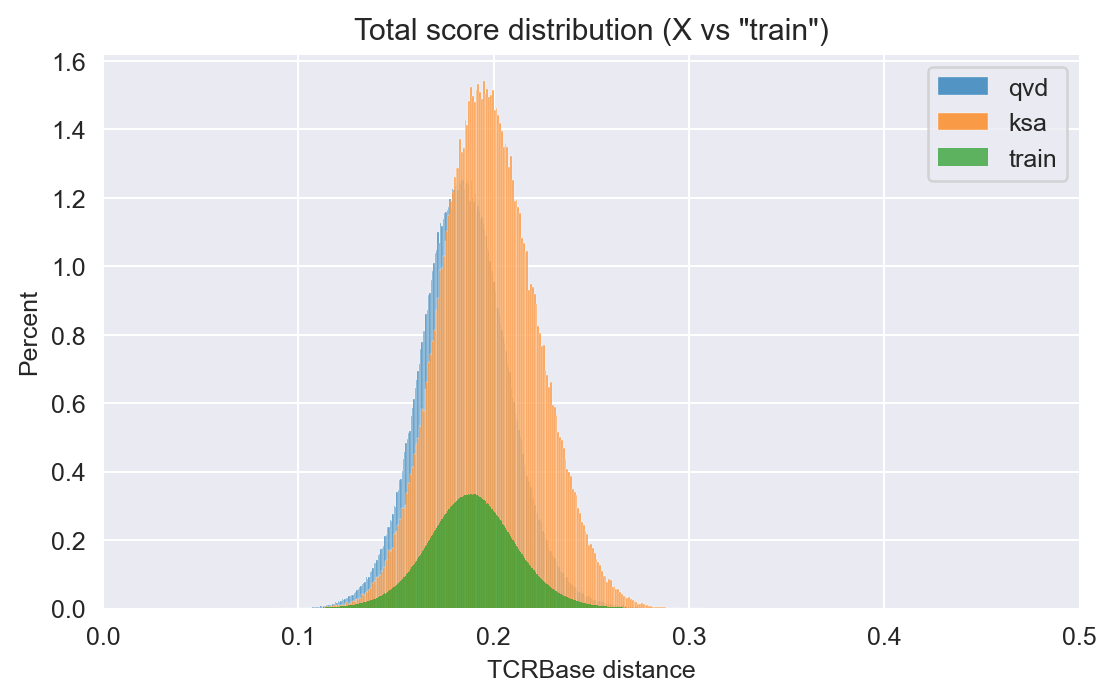

In [137]:
fig,ax = plt.subplots(1,1, figsize=(7,4))
tmp_values = tmp.iloc[:len(tmp), :len(tmp)].values.flatten()
sns.histplot(qvd[[x for x in qvd.columns if x.isnumeric()]].values.flatten(), ax=ax, label='qvd', stat='percent')
sns.histplot(ksa[[x for x in ksa.columns if x.isnumeric()]].values.flatten(), ax=ax, label='ksa', stat='percent')
sns.histplot(tmp_values[tmp_values!=0], label='train', ax=ax, stat='percent')
ax.legend()
ax.set_xlabel('TCRBase distance')
ax.set_xlim([0,0.5])
ax.set_title('Total score distribution (X vs "train")')

Text(0.5, 1.0, 'Best score distribution (X vs "train")')

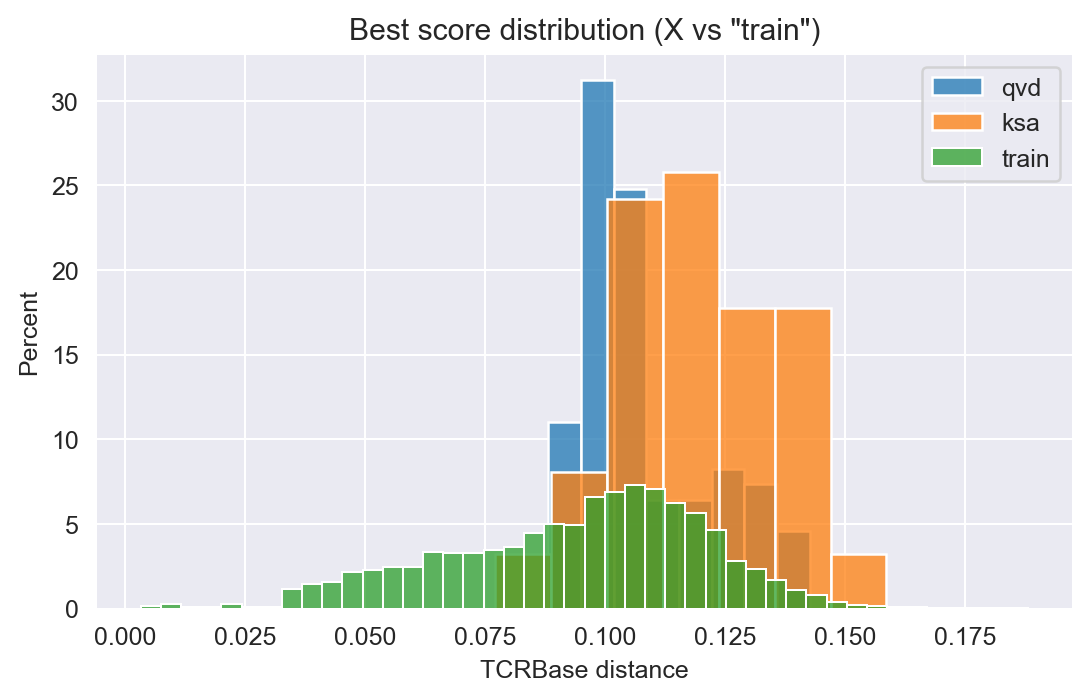

In [138]:
fig,ax = plt.subplots(1,1, figsize=(7,4))
sns.histplot(qvd['matched_score'].values.flatten(), ax=ax, label='qvd', stat='percent')
sns.histplot(ksa['matched_score'].values.flatten(), ax=ax, label='ksa', stat='percent')
sns.histplot(tmp['matched_score'].values.flatten(), label='train', ax=ax, stat='percent')
ax.legend()
ax.set_xlabel('TCRBase distance')
ax.set_title('Best score distribution (X vs "train")')

# Something else ?

In [151]:
len("""
51428717
51428718
51428719
51428720
51428721
51428722
51428723
51428724
51428725
51428726
51428727
51428728
51428729
51428730
51428731
51428732
51428733
51428734
51428735
51428736
51428737
51428738
51428739
51428740
51428741
51428742
51428743
51428744
51428745
51428746
51428747
51428748
51428749
51428750
51428751
51428752
51428753
51428754
51428755
51428756
51428757
51428758
51428759
51428760
51428761
51428762
51428763
51428764
51428765
51428766
51428767
51428768
51428769
51428770
51428771
51428772
51428773
51428774
51428775
51428776
51428777
51428778
51428779
51428780
51428781
51428782
51428783
51428784
51428785
51428786
51428787
51428788
51428789
51428790
51428791
51428792
51428793
51428794
51428795
51428796
51428797
51428798
51428799
51428800
51428801
51428802
51428803
51428804
51428805
51428806
51428807
51428808
51428809
51428810
51428811
51428812
51428813
51428814
51428815
51428816
51428817
51428818
51428819
51428820
51428821
51428822
51428823
51428824
51428825
51428826
51428827
51428828
51428829
51428830
51428831
51428832
51428833
51428834
51428835
51428836
51428837
51428838
51428839
51428840
51428841
51428842
51428843
51428844
51428845
51428846
51428847
51428848
51428849
51428850
51428851
51428852
51428853
51428854
51428855
51428856
51428857
51428858
51428859
51428860
51428861
51428862
51428863
51428864
51428865
51428866
51428867
51428868
51428869
51428870
51428871
51428872
51428873
51428874
51428875
51428876
51428877
51428878
51428879
51428880
51428881
51428882
51428883
51428884
51428885
51428886
51428887
51428888
51428889
51428890
51428891
51428892
51428893
51428894
51428895
51428896
51428897
51428898
51428899
51428900
51428901
51428902
51428903
51428904
51428905
51428906
51428907
51428908
51428909
51428910
51428911
51428912
51428913
51428914
51428915
51428916
51428917
51428918
51428919
51428920
51428921
51428922
51428923
51428924
51428925
51428926
51428927
51428928
51428929
51428930
51428931
51428932
51428933
51428934
51428935
51428936
51428937
51428938
51428939
51428940
51428941
51428942
51428943
51428944
51428945
51428946
51428947
51428948
51428949
51428950
51428951
51428952
51428953
51428954
51428955
51428956
51428957
51428958
51428959
51428960
51428961
51428962
51428963
51428965
51428966
51428967
51428968
51428969
51428970
51428971
51428972
51428973
51428974
51428975
51428976
51428977
51428978
51428979
51428980
51428981
51428982
51428983
51428984
51428985
51428986
51428987
51428988
51428989
51428990
51428991
51428992
51428993
51428994
51428995
51428996
51428997
51428998
51428999
51429000
51429001
51429002
51429003
51429004
51429005
51429006
51429007
51429008
51429009
51429010
51429011
51429012
51429013
51429014
51429015
51429016
51429017
51429018
51429019
51429020
51429021
51429022
51429023
51429024
51429025
51429026
51429027
51429028
51429029
51429030
51429031
51429032
51429033
51429034
51429035
51429036
51429037
51429038
51429039
51429040
51429041
51429042
51429043
51429044
51429045
51429046
51429047
51429048
51429049
51429050
51429051
51429052
51429053
51429054
51429055
51429056
51429057
51429058
51429059
51429060
51429061
51429062
51429063
51429064
51429065
51429066
51429067
51429068
51429069
51429070
51429071
51429072
51429073
51429074
51429075
51429076
51429077
51429078
	51429079
51429080
51429081
51429082
51429083
51429084
51429085
51429086
51429087
51429088
51429089
51429090
51429091
51429092
51429093
51429094
51429095
51429096
51429097
51429098
51429099
51429100
51429101
51429102
51429103
51429104
51429105
51429106
51429107
51429108
51429109
51429110
51429111
51429112
51429113
51429114
51429115
51429116
51429117
51429118
51429119
51429120
51429121
51429122
51429123
51429124
51429125
51429126
51429127
51429128
51429129
51429130
51429131
51429132
51429133
51429134
51429135
51429136
51429137
51429138
51429139
51429140
51429141
51429142
51429143
51429144
51429145
51429146
51429147
51429148
51429149
51429150
51429151
51429152
51429153
51429154
51429155
51429156
51429157
51429158
51429159
51429160
51429161
51429162
51429163
51429164
51429165
51429166
51429167
51429168
51429169
51429170
51429171
51429172
51429173
51429174
51429175
51429176
51429177
51429178
51429179
51429180
51429181
51429182
51429183
51429184
51429185
51429186
51429187
51429188
51429189
51429190
51429191
51429192
51429193
51429194
51429195
51429196
51429197
51429198
51429199
51429200
51429201
51429202
51429203
51429204
51429205
51429206
51429207
51429208
51429209
51429210
51429211
51429212
51429213
51429214
51429215
51429216
51429217""".split('\n'))

501